# Proyecto RNN

##### Statistical Learning II
##### Gustavo Alvarado
##### Carnet # 20063401 

## Tema 
Predicción del álbum al que pertenece una canción

## Fuentes de datos

* Spotify API. https://developer.spotify.com/documentation/web-api/ 

In [1]:
!pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 13.2 MB/s 
     |████████████████████████████████| 246 kB 49.7 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [24]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [204]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import spotipy
import librosa
import librosa.display
import os
import requests
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.model_selection import train_test_split
from pydub import AudioSegment
import datetime
from datetime import datetime

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from keras import optimizers

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Conexión al API de Spotify

Conexión a Spotify API utilizando las herramientas para developers de Spotify con cuenta personal, y la librería **spotipy**. creando una aplicación API y generando credenciales correspondinetes. En la cuenta personal de Spotify se encuentera un playlist que incluye todas las canciones de toda la discografía del grupo Metallica, que es con el que se entrenará el modelo. 

In [296]:
client_credentials_manager = SpotifyClientCredentials(client_id='5d7ab1656719472d87e78d3869d54a84', client_secret='8c74e7a5644040d4b5b940dfb2860b85')
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [297]:
#Playlist de discografía de Metallica
playlist_link = 'https://open.spotify.com/playlist/3qRjp44bvsVi7x33qox9zD?si=498b6e1091d345c9'
playlist_URI = playlist_link.split('/')[-1].split('?')[0]
track_uris = [x['track']['uri'] for x in sp.playlist_tracks(playlist_URI)['items']]

In [298]:
#Obteniendo lista de canciones, generando album_id numérico de forma cronológica
track_dict = {'id': [], 'track': [], 'artists': [], 'album_name': [],  'year': [], 'preview_url': [], 'album_id': []}

i = 1
current_album = ''
album_id = -1

for track in sp.playlist_tracks(playlist_URI)['items']:
  if track['track']['album']['name'] != current_album:
    current_album = track['track']['album']['name']
    album_id += 1
  
  for col in track_dict.keys():
    if col == 'id':
      track_dict['id'].append(i)
      continue
    if col == 'track':
      track_dict['track'].append(track['track']['name'])
      continue
    if col == 'artists':
      track_dict['artists'].append([a['name'] for a in track['track']['artists']])
      continue
    if col == 'album_name':
      track_dict['album_name'].append(track['track']['album']['name'])
      continue
    if col == 'year':
      track_dict['year'].append(track['track']['album']['release_date'][0:4])
      continue
    if col == 'preview_url':
      track_dict['preview_url'].append(track['track']['preview_url'])
      continue
    if col == 'album_id':
      track_dict[col].append(album_id)

  i += 1
df = pd.DataFrame(track_dict)
df
   

,id,track,artists,album_name,year,preview_url,album_id
0,1,Hit The Lights - Remastered,[Metallica],Kill 'Em All (Remastered),1983,https://p.scdn.co/mp3-preview/b8659b491e78b3ab...,0
1,2,The Four Horsemen - Remastered,[Metallica],Kill 'Em All (Remastered),1983,https://p.scdn.co/mp3-preview/eedb0a9d2e9dcaf3...,0
2,3,Motorbreath - Remastered,[Metallica],Kill 'Em All (Remastered),1983,https://p.scdn.co/mp3-preview/c75aa7c5634283fe...,0
3,4,Jump In The Fire - Remastered,[Metallica],Kill 'Em All (Remastered),1983,https://p.scdn.co/mp3-preview/b89d8d0a6dd6a7af...,0
4,5,(Anesthesia) Pulling Teeth - Remastered,[Metallica],Kill 'Em All (Remastered),1983,https://p.scdn.co/mp3-preview/57dac87f1a7a2a7a...,0
...,...,...,...,...,...,...,...
95,96,Hardwired,[Metallica],Hardwired…To Self-Destruct,2016,https://p.scdn.co/mp3-preview/3a69843c06b397e8...,9
96,97,"Atlas, Rise!",[Metallica],Hardwired…To Self-Destruct,2016,https://p.scdn.co/mp3-preview/7de56a1296ef8c74...,9
97,98,Now That We’re Dead,[Metallica],Hardwired…To Self-Destruct,2016,https://p.scdn.co/mp3-preview/56ed126ee238ba6b...,9
98,99,Moth Into Flame,[Metallica],Hardwired…To Self-Destruct,2016,https://p.scdn.co/mp3-preview/6e9ad146afd27281...,9


## Muestra de canciones

Spotify API no permite obtener la versión completa de una canción, permite obtener una previsualización o muestra de cada canción de aproximadamente 30 segundos. 

In [13]:
from IPython.display import Audio

In [70]:
#Previsualización de la canción 'Master of Puppets'
song = Audio(url=df['preview_url'][21] + '.mp3', autoplay = False, embed = True)
song

In [36]:
#Previsualización de la canción 'Enter Sandman'
song = Audio(url=df['preview_url'][35] + '.mp3', autoplay = False, embed = True)
song

## Definición de variables

In [187]:
X = df.drop(columns=['album_id'])
y = df['album_id']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [169]:
X_train

,id,track,artists,album_name,year,preview_url
18,19,Battery,[Metallica],Master Of Puppets (Remastered),1986,https://p.scdn.co/mp3-preview/f9ee15dc35c894c8...
30,31,The Shortest Straw,[Metallica],...And Justice For All,1988,https://p.scdn.co/mp3-preview/dad8e8acb096b3a9...
73,74,Fixxxer,[Metallica],Reload,1997,https://p.scdn.co/mp3-preview/26d46058daad7d47...
33,34,To Live Is To Die,[Metallica],...And Justice For All,1988,https://p.scdn.co/mp3-preview/5b5ffbe02c5200e2...
90,91,Cyanide,[Metallica],Death Magnetic,2008,https://p.scdn.co/mp3-preview/60be440a317e97b7...
...,...,...,...,...,...,...
60,61,The Outlaw Torn,[Metallica],Load,1996,https://p.scdn.co/mp3-preview/42bcd3424ce06d75...
71,72,Low Man's Lyric,[Metallica],Reload,1997,https://p.scdn.co/mp3-preview/86695f276785153b...
14,15,Trapped Under Ice - Remastered,[Metallica],Ride The Lightning (Remastered),1984,https://p.scdn.co/mp3-preview/4e3ffcc60f0ce9a5...
92,93,The Judas Kiss,[Metallica],Death Magnetic,2008,https://p.scdn.co/mp3-preview/d248838c36de6630...


In [188]:
y_train

18    2
30    3
73    6
33    3
90    8
     ..
60    5
71    6
14    1
92    8
51    5
Name: album_id, Length: 90, dtype: int64

## Descargando mp3

Para continuar con el pre-procesamiento de los datos, se descargan las canciones del set de entrenamiento y de pruebas a un directorio específico en Google Drive. 

In [171]:
#Path de datos de entrenamiento y prueba
strDataTrain = '/content/gdrive/My Drive/SLII/Project/Metallica/data/X_train'
strDataTest =  '/content/gdrive/My Drive/SLII/Project/Metallica/data/X_test'

In [79]:
#Descargando mp3 de entrenamiento
for i, row in X_train.iterrows():
  id = row['id']
  r = requests.get(row['preview_url'])
  with open(f'{strDataTrain}/mp3/{id}.mp3', 'wb') as f:
    f.write(r.content)

In [80]:
#Descargando mp3 de prueba
for i, row in X_test.iterrows():
  id = row['id']  
  r = requests.get(row['preview_url'])
  with open(f'{strDataTest}/mp3/{id}.mp3', 'wb') as f:
    f.write(r.content)

## Convirtiendo a wav

Es necesario convertir los archivos mp3 obtenidos en el paso anterior a archivos wav, utiliando la librería **AudioSegment**.

In [81]:
#Convirtiendo mp3 a wav de entrenamiento
for file in os.listdir(strDataTrain + '/mp3'):
  src = f'{strDataTrain}/mp3/{file}'
  dest = f'{strDataTrain}/wav/{file.split(".")[0]}.wav'
  AudioSegment.from_mp3(src).export(dest, format='wav')


In [82]:
#Convirtiendo mp3 a wav de prueba
for file in os.listdir(strDataTest + '/mp3'):
  src = f'{strDataTest}/mp3/{file}'
  dest = f'{strDataTest}/wav/{file.split(".")[0]}.wav'
  AudioSegment.from_mp3(src).export(dest, format='wav')

## Visualizando waveforms

Utilizando librería **librosa** para obtener la *waveform* de una canción

[Text(93.375, 0.5, 'Amplitud'),
 Text(0.5, 24.0, 'Timempo (sec)'),
 Text(0.5, 1.0, 'Waveform')]

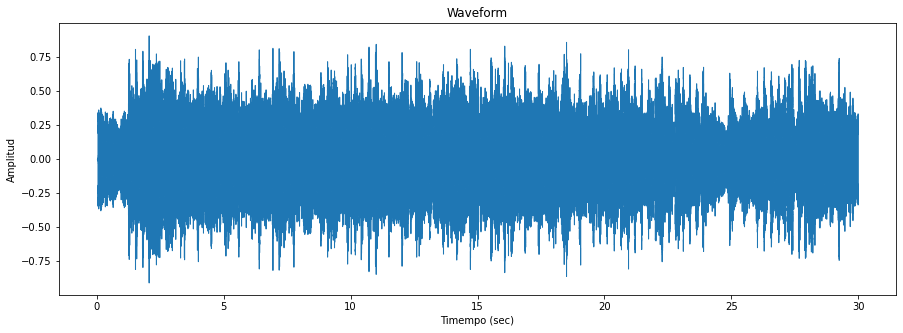

In [172]:
# Visualizando waveform de la canción 'Master of puppets'
y1, sr1 = librosa.load(strDataTrain + '/wav/21.wav')
fig1, ax1 = plt.subplots(figsize=(15,5))
librosa.display.waveshow(y1, sr=sr1, ax=ax1);
ax1.set(title='Waveform', xlabel='Timempo (sec)', ylabel='Amplitud')

[Text(93.375, 0.5, 'Amplitud'),
 Text(0.5, 24.0, 'Timempo (sec)'),
 Text(0.5, 1.0, 'Waveform')]

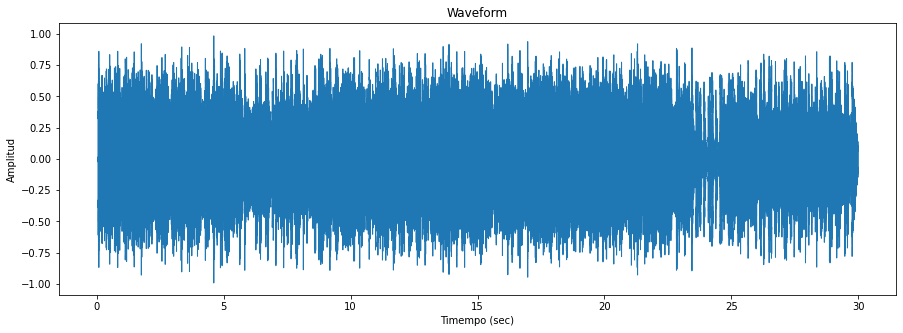

In [87]:
# Visualizando waveform de la canción 'Enter Sandman'
y2, sr2 = librosa.load(strDataTrain + '/wav/35.wav')
fig2, ax2 = plt.subplots(figsize=(15,5))
librosa.display.waveshow(y2, sr=sr2, ax=ax2);
ax2.set(title='Waveform', xlabel='Timempo (sec)', ylabel='Amplitud')

## Visualizando espectograma Mel 

Para entrenar un modelo con RNN de audio, la mejor opción es hacerlo con espectogramas, utilizando los coeficientes de la frecuencia Mel (MFCC). Esto también se puede calcular y visualizar con la librería **librosa**. 

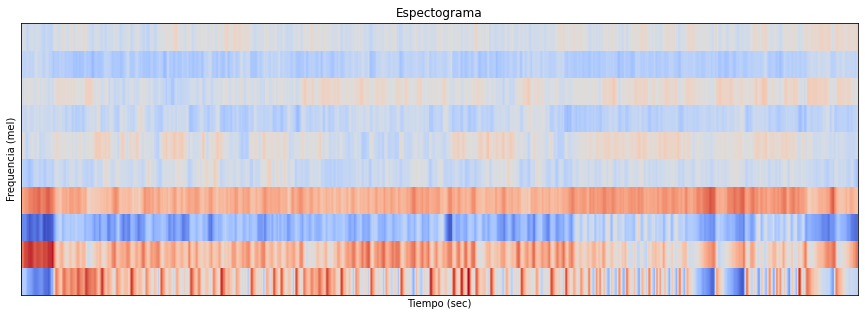

In [261]:
# Visualizando espectograma de la canción 'Master of puppets'

y1, sr1 = librosa.load(strDataTrain + '/wav/21.wav')
MFCC1 = librosa.feature.mfcc(y=y1, sr=sr1, n_mfcc=10, n_fft=4168, hop_length=256)
fig1, ax1 = plt.subplots(figsize=(15,5))
librosa.display.specshow(MFCC1, sr=sr1)
ax1.set(title='Espectograma', xlabel='Tiempo (sec)', ylabel='Frequencia (mel)')
plt.show()


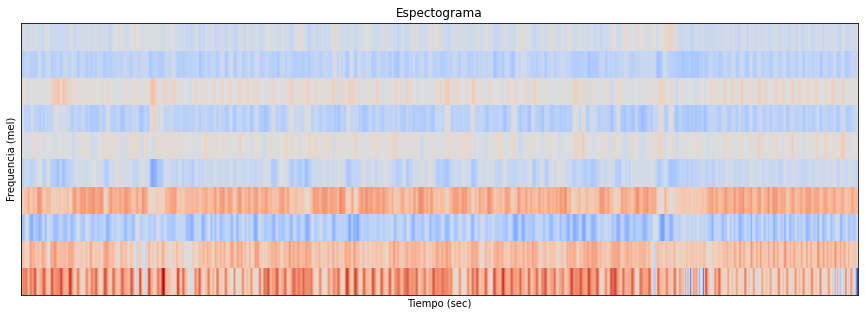

In [262]:
# Visualizando espectograma de la canción 'Enter sandman'

y2, sr2 = librosa.load(strDataTrain + '/wav/35.wav')
MFCC2 = librosa.feature.mfcc(y=y2, sr=sr2, n_mfcc=10, n_fft=4168, hop_length=256)
fig2, ax2 = plt.subplots(figsize=(15,5))
librosa.display.specshow(MFCC2,sr=sr2)
ax2.set(title='Espectograma', xlabel='Tiempo (sec)', ylabel='Frequencia (mel)')
plt.show()

## Extrayendo features

Los valores de X serán el conjunto de espectogramas de las canciones, tanto de los datos de entrenamiento como los datos de prueba. 

In [267]:
X_train_s = []
for i in range(0, len(X_train)):
  y, sr = librosa.load(strDataTrain + '/wav/' + str(X_train.iloc[i]['id']) + '.wav')
  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=2084, hop_length=512)
  X_train_s.append(mfcc)

In [268]:
#Normalizando
#X_train_s = np.array((X_train_s - np.min(X_train_s)) / (np.max(X_train_s) - np.min(X_train_s)))
#X_train_s = X_train_s / np.std(X_train_s)
X_train_s = np.array(X_train_s)
y_train = np.array(y_train)

In [269]:
X_test_s = []
for i in range(0, len(X_test)):
  y, sr = librosa.load(strDataTest + '/wav/' + str(X_test.iloc[i]['id']) + '.wav')
  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=2084, hop_length=512)
  X_test_s.append(mfcc)

In [270]:
#Normalizando
#X_test_s = np.array((X_test_s - np.min(X_test_s)) / (np.max(X_test_s) - np.min(X_test_s)))
#X_test_s = X_test_s / np.std(X_test_s)
X_test_s = np.array(X_test_s)
y_test = np.array(y_test)

In [271]:
X_train_s.shape, y_train.shape, X_test_s.shape, y_test.shape

((90, 13, 1292), (90,), (10, 13, 1292), (10,))

## Implementando RNN

Se implementará RNN con LTMS (*Long Short-Term Memory*).

### Experimento 1

In [278]:
rnn1 = Sequential()
rnn1.add(LSTM(80,input_shape=(13, 1292)))
rnn1.add(Dropout(0.2))
rnn1.add(Dense(80, activation='relu'))
rnn1.add(Dense(40, activation='relu'))
rnn1.add(Dropout(0.4))
rnn1.add(Dense(20, activation='relu'))
rnn1.add(Dropout(0.4))
rnn1.add(Dense(10, activation='softmax'))
rnn1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 80)                439360    
                                                                 
 dropout_38 (Dropout)        (None, 80)                0         
                                                                 
 dense_52 (Dense)            (None, 80)                6480      
                                                                 
 dense_53 (Dense)            (None, 40)                3240      
                                                                 
 dropout_39 (Dropout)        (None, 40)                0         
                                                                 
 dense_54 (Dense)            (None, 20)                820       
                                                                 
 dropout_40 (Dropout)        (None, 20)              

In [279]:
rnn1.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [265]:
album_dict = {1: ''}

In [281]:
history1 = rnn1.fit(X_train_s, y_train, epochs=1000, shuffle=False)

Epoch 1/1000
3/3 [==============================] - 0s 82ms/step - loss: 2.2026 - accuracy: 0.1778
Epoch 2/1000
3/3 [==============================] - 0s 64ms/step - loss: 2.2169 - accuracy: 0.1889
Epoch 3/1000
3/3 [==============================] - 0s 32ms/step - loss: 2.2572 - accuracy: 0.1333
Epoch 4/1000
3/3 [==============================] - 0s 34ms/step - loss: 2.2140 - accuracy: 0.1556
Epoch 5/1000
3/3 [==============================] - 0s 34ms/step - loss: 2.2399 - accuracy: 0.1778
Epoch 6/1000
3/3 [==============================] - 0s 36ms/step - loss: 2.2546 - accuracy: 0.1111
Epoch 7/1000
3/3 [==============================] - 0s 34ms/step - loss: 2.2258 - accuracy: 0.1444
Epoch 8/1000
3/3 [==============================] - 0s 38ms/step - loss: 2.2354 - accuracy: 0.1111
Epoch 9/1000
3/3 [==============================] - 0s 36ms/step - loss: 2.1993 - accuracy: 0.1667
Epoch 10/1000
3/3 [==============================] - 0s 34ms/step - loss: 2.1792 - accuracy: 0.1778
Epoch 11/

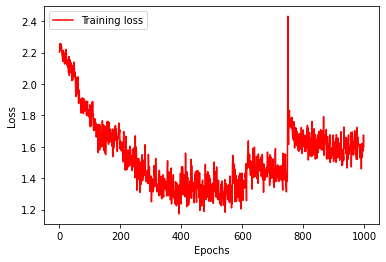

In [282]:
plt.plot(history1.history['loss'],'r')
plt.legend(['Training loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

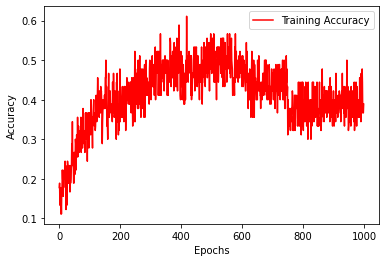

In [292]:
plt.plot(history1.history['accuracy'],'r')
plt.legend(['Training Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Experimento # 2

In [288]:
rnn2 = Sequential()
rnn2.add(LSTM(64,input_shape=(13, 1292), return_sequences=True))
rnn2.add(LSTM(64))
rnn2.add(Dense(64, activation='relu'))
rnn2.add(Dropout(0.3))
rnn2.add(Dense(10, activation='softmax'))
rnn2.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 13, 64)            347392    
                                                                 
 lstm_20 (LSTM)              (None, 64)                33024     
                                                                 
 dense_58 (Dense)            (None, 64)                4160      
                                                                 
 dropout_42 (Dropout)        (None, 64)                0         
                                                                 
 dense_59 (Dense)            (None, 10)                650       
                                                                 
Total params: 385,226
Trainable params: 385,226
Non-trainable params: 0
_________________________________________________________________


In [289]:
rnn2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [290]:
history2 = rnn2.fit(X_train_s, y_train, epochs=200, shuffle=False)

Epoch 1/200
3/3 [==============================] - 4s 41ms/step - loss: 2.2895 - accuracy: 0.1667
Epoch 2/200
3/3 [==============================] - 0s 37ms/step - loss: 2.2259 - accuracy: 0.1667
Epoch 3/200
3/3 [==============================] - 0s 36ms/step - loss: 2.1751 - accuracy: 0.2667
Epoch 4/200
3/3 [==============================] - 0s 36ms/step - loss: 2.1139 - accuracy: 0.2778
Epoch 5/200
3/3 [==============================] - 0s 36ms/step - loss: 2.0589 - accuracy: 0.3444
Epoch 6/200
3/3 [==============================] - 0s 36ms/step - loss: 1.9446 - accuracy: 0.4333
Epoch 7/200
3/3 [==============================] - 0s 35ms/step - loss: 1.9322 - accuracy: 0.4000
Epoch 8/200
3/3 [==============================] - 0s 37ms/step - loss: 1.8107 - accuracy: 0.4333
Epoch 9/200
3/3 [==============================] - 0s 37ms/step - loss: 1.7014 - accuracy: 0.5111
Epoch 10/200
3/3 [==============================] - 0s 36ms/step - loss: 1.5894 - accuracy: 0.5778
Epoch 11/200
3/3 [=

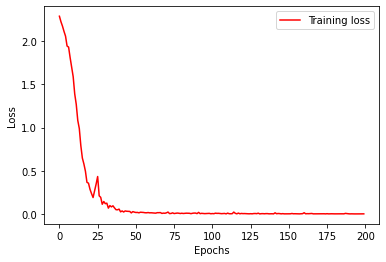

In [294]:
plt.plot(history2.history['loss'],'r')
plt.legend(['Training loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

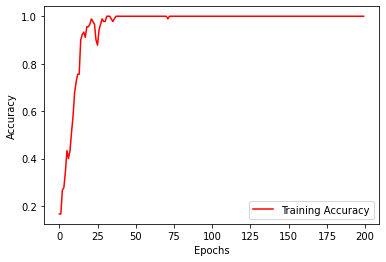

In [295]:
plt.plot(history2.history['accuracy'],'r')
plt.legend(['Training Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## Predicción

El modelo generado por el experimento # 2 genera una exactitud cerana a 100%, por lo que se utilizará este mismo para poder predecir los datos de los valores de prueba. 

In [299]:
albums = ['Kill ''Em All', 'Ride the Lightning', 'Master of Puppets', '..And Justice for All', 'Metallica', 'Load', 'Reload', 'St. Anger', 'Death Magnetic', 'Hardwired... to Self-Destruct']

In [316]:
X_test

,id,track,artists,album_name,year,preview_url
83,84,Purify,[Metallica],St. Anger,2003,https://p.scdn.co/mp3-preview/7e4a278c488b6ce4...
53,54,Bleeding Me,[Metallica],Load,1996,https://p.scdn.co/mp3-preview/596b8d15de9e5a9b...
70,71,Prince Charming,[Metallica],Reload,1997,https://p.scdn.co/mp3-preview/3532f1e1fb2149b5...
45,46,My Friend Of Misery,[Metallica],Metallica,1991,https://p.scdn.co/mp3-preview/31a7f696116b61d1...
44,45,The God That Failed,[Metallica],Metallica,1991,https://p.scdn.co/mp3-preview/c8320445ef8e9cca...
39,40,Wherever I May Roam,[Metallica],Metallica,1991,https://p.scdn.co/mp3-preview/05ebcdc8b0a622fc...
22,23,Disposable Heroes,[Metallica],Master Of Puppets (Remastered),1986,https://p.scdn.co/mp3-preview/8acde7b27acff9b1...
80,81,Shoot Me Again,[Metallica],St. Anger,2003,https://p.scdn.co/mp3-preview/12a4ca184f2bd2e4...
10,11,Fight Fire With Fire - Remastered,[Metallica],Ride The Lightning (Remastered),1984,https://p.scdn.co/mp3-preview/89f671cbe14c650f...
0,1,Hit The Lights - Remastered,[Metallica],Kill 'Em All (Remastered),1983,https://p.scdn.co/mp3-preview/b8659b491e78b3ab...


In [352]:
def predictAlbum(song):
  index = 0
  for row in X_test.values:
    if row[1] == song:
      print('Album:', row[3])
      break
    index +=1
  
  album_predict = rnn2.predict(X_test_s[[index]])
  album_predict = album_predict.tolist()
  print('Predicted Album:', albums[album_predict[0].index(max(album_predict[0]))])
  return


In [353]:
predictAlbum('Purify')

Album: St. Anger
Predicted Album: St. Anger


In [354]:
predictAlbum('Bleeding Me')

Album: Load
Predicted Album: Reload


In [357]:
predictAlbum('My Friend Of Misery')

Album: Metallica
Predicted Album: ..And Justice for All


In [365]:
predictAlbum('Wherever I May Roam')

Album: Metallica
Predicted Album: ..And Justice for All


In [366]:
predictAlbum('Disposable Heroes')

Album: Master Of Puppets (Remastered)
Predicted Album: ..And Justice for All


In [367]:
predictAlbum('Shoot Me Again')

Album: St. Anger
Predicted Album: Load


In [368]:
predictAlbum('Fight Fire With Fire - Remastered')

Album: Ride The Lightning (Remastered)
Predicted Album: Kill Em All


## Conclusiones
El modelo parece tener exactitud en los datos de entrenamiento, sin embargo en los datos de prueba, los resultados no son exactamente los esperados. De los 10 datos de prueba, únicamente 1 canción fue obtenida correctamente a través del modelo (Purify). Sin embargo, se puede observar que las predicciones tienden a tener 1 o dos discos de distancia cronológica. 

Esto puede significar que posiblemente el sonido del grupo Metallica se mantenga muy similar en discos lanzados en épocas cercanas, y por tal motivo, el modelo encontro similitudes en el espectro de sonido. 

Si los discos se agruparan en "clústers" de discos cronológicamente en base a su espectro de sonido promedio, posiblemente el modelo pudiera ser más efectivo. 